In [5]:
%%pyspark
df = spark.read.load('', format='csv'

, header=True
)
display(df)

StatementMeta(sparkpool, 6, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7691e7dd-2567-48f2-85c9-f8526fcc06ca)

In [8]:
final_df = df.select(['recency','frequency','monetary_value','CustomerID']).distinct()

StatementMeta(sparkpool, 6, 8, Finished, Available, Finished)

In [33]:
from pyspark.sql.functions import col
# Chuyển recency thành long (số nguyên dài)
final_df = final_df.withColumn("recency", col("recency").cast("long"))

# Chuyển frequency thành int (số nguyên)
final_df = final_df.withColumn("frequency", col("frequency").cast("int"))

# Chuyển monetary_value thành decimal (hoặc double nếu muốn)
final_df = final_df.withColumn('monetary_value', col('monetary_value').cast('float'))

StatementMeta(sparkpool, 6, 33, Finished, Available, Finished)

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

StatementMeta(sparkpool, 6, 34, Finished, Available, Finished)

Triển khai học máy

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

StatementMeta(sparkpool, 6, 35, Finished, Available, Finished)

StatementMeta(sparkpool, 6, 36, Finished, Available, Finished)

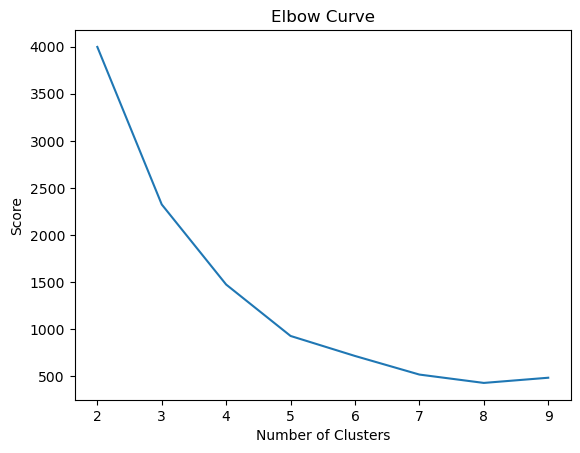

In [36]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [37]:
#train 
kmeans_algo=KMeans(featuresCol='standardized', k=4)
kmeans_fit=kmeans_algo.fit(data_scale_output)

StatementMeta(sparkpool, 6, 37, Finished, Available, Finished)

In [38]:
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)

StatementMeta(sparkpool, 6, 38, Finished, Available, Finished)

+-----------+---------+--------------+----------+--------------------+--------------------+----------+
|    recency|frequency|monetary_value|CustomerID|            features|        standardized|prediction|
+-----------+---------+--------------+----------+--------------------+--------------------+----------+
|28188540000|       41|        888.54|   13598.0|[2.818854E10,41.0...|[3.32954231013386...|         0|
|31979520000|      121|       1500.13|   14825.0|[3.197952E10,121....|[3.77732102825375...|         0|
| 5014440000|       11|        528.95|   12574.0|[5.01444E9,11.0,5...|[0.59228999237376...|         1|
|24131040000|        2|         12.13|   13130.0|[2.413104E10,2.0,...|[2.85028308197348...|         0|
|21713580000|       82|        369.66|   13162.0|[2.171358E10,82.0...|[2.56474025666020...|         0|
+-----------+---------+--------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



StatementMeta(sparkpool, 6, 39, Finished, Available, Finished)

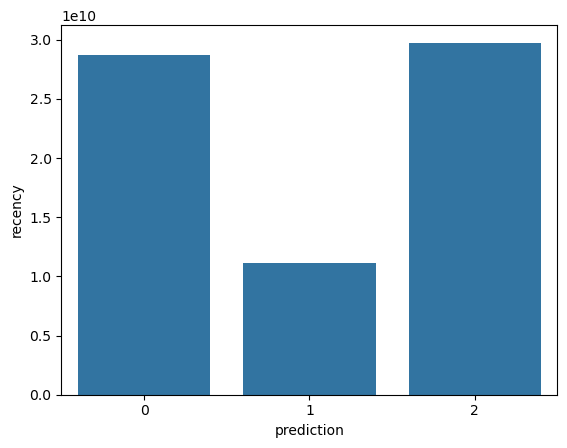

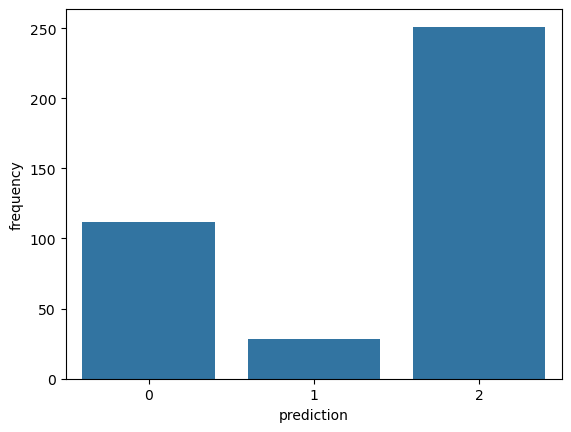

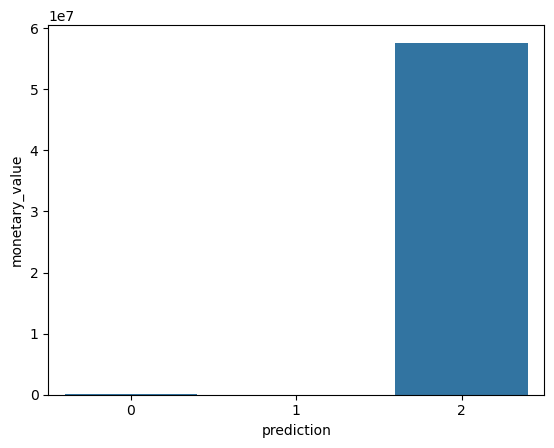

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()
